# Análise de Dados Exploratória da ANAC

![ANAC](imgs/anac-logo.png "Logo ANAC")

# 1. Introdução

Este estudo tem como objetivo analisar um conjunto de dados de voos internacionais registrados pela Agência Nacional de Aviação Civil (ANAC) do Brasil, durante o período de janeiro de 2015 a agosto de 2017. 

A ANAC é a agência reguladora responsável pela aviação civil no país, e as informações contidas nesses dados são de grande importância para a compreensão da dinâmica da aviação internacional no Brasil, bem como para a tomada de decisões estratégicas no setor. O conjunto de dados inclui informações como o número do voo, nome da companhia aérea, horários de partida e chegada previstos e reais, situação do voo e localização dos aeroportos de origem e destino, entre outros. Esses dados permitem uma análise detalhada das tendências e padrões de voos internacionais no Brasil, bem como a identificação de fatores que possam influenciar o desempenho da aviação internacional no país.

## 1.1. Objetivos

O objetivo deste estudo é realizar uma Análise Exploratória dos Dados (Exploratory Data Analysis - EDA) do conjunto de dados disposto em [bases/](bases/), e analisar dados de voos internacionais rastreados pela ANAC.

Com base nas informações disponíveis, pretendemos avaliar o desempenho das companhias aéreas em relação ao cumprimento dos horários previstos de partida e chegada, bem como investigar a frequência de cancelamentos e as justificativas apresentadas para esses casos. 

Também vamos examinar as rotas mais utilizadas e os destinos mais comuns para os voos internacionais saindo do Brasil, bem como avaliar a pontualidade e a eficiência dos aeroportos de origem e destino. 

1. [3.1. Qual destino mais procurado nas férias? (julho, dezembro e janeiro)](#)
1. [3.1.1. Principais destinos regionais](#)
1. [3.1.2. Principais destinos nacionais](#)
1. [3.1.3. Principais destinos internacionais](#)
1. [3.2. Como ficam os aeroportos nesses meses?](#)
1. [3.2.1. Atrasos](#)
1. [3.2.2. Cancelamentos](#)
1. [3.2.1. Atrasos](#)
1. [3.3. Qual a melhor opção uma viagem nacional ou internacional?](#)
1. [3.4. Qual a melhor rota?](#)
1. [3.5. Qual melhor dia da semana para pegar um vôo?](#)


# 2. Metodologia

Nesta seção será apresentado todo o processo de preparação, organização e limpeza de dados feito no *dataset* que possui os seguintes dados brutos. Ao final desta, apresentaremos os dados padronizados e devidamente tratados:

|        Coluna        | Tipo |                         Descrição                         |
|:--------------------:|:----:|:---------------------------------------------------------:|
|         Voos         |  str |                       Número do voo                       |
|    Companhia.Aerea   |  str |                  Nome da companhia aérea                  |
|   Codigo.Tipo.Linha  |  str |          Código do tipo de linha (internacional)          |
|   Partida.Prevista   |  str |                Horário previsto de partida                |
|     Partida.Real     |  str |                  Horário real de partida                  |
|   Chegada.Prevista   |  str |                Horário previsto de chegada                |
|     Chegada.Real     |  str |                  Horário real de chegada                  |
|     Situacao.Voo     |  str |        Situação do voo (realizado, cancelado, etc)        |
| Codigo.Justificativa |  str | Código de justificativa (caso o voo tenha sido cancelado) |
|   Aeroporto.Origem   |  str |               Código do aeroporto de origem               |
|     Cidade.Origem    |  str |                      Cidade de origem                     |
|     Estado.Origem    |  str |                      Estado de origem                     |
|      Pais.Origem     |  str |                       País de origem                      |
|   Aeroporto.Destino  |  str |               Código do aeroporto de destino              |
|    Cidade.Destino    |  str |                     Cidade de destino                     |
|    Estado.Destino    |  str |                     Estado de destino                     |
|     Pais.Destino     |  str |                      País de destino                      |
|       LongDest       |  str |             Longitude do aeroporto de destino             |
|        LatDest       |  str |              Latitude do aeroporto de destino             |
|       LongOrig       |  str |              Longitude do aeroporto de origem             |
|        LatOrig       |  str |              Latitude do aeroporto de origem              |


## 2.1. Configuração do Ambiente

### 2.1.1. Bibliotecas e Ferramentas Necessárias (Built-ins)

1. ```os```:       Para manipular os arquivos de base e seus respectivos diretórios de forma multiplataforma e eficiente.
2. ```re```:       Utilizado em expressões regulares durante o processo de limpeza dos dados.
3. ```enum```:     Auxilia nos processos de padronizar e regular algumas convenções do projeto.
4. ```datetime```, ```time```: Auxilia nos processos de padronizar e regular algumas convenções do projeto.
4. ```typing```: definir tipos em documentações e assinaturas.

### 2.1.2. Bibliotecas e Ferramentas Necessárias (pip)

1. Pandas: Para manipular e exibir os dados de forma coesa e relata.   
    ```pip install pandas```       
    ```import pandas as pd```

2. JinJa2: Complemento de estilização do Pandas.   
    ```pip install Jinja2```

4. Utils: Contém uma série de métodos auxiliares nos processos de organização, limpeza e feature engineering.     
    ```from libs.utils import Utils```

5. Plot: Contém os métodos e regras de negócio para plotar os gráficos.     
    ```from libs.utils import Plot```

5. AnacVoos: Contém Responsável por armazenar,controlar e servir os dados.     
    ```from libs.utils import AnacVoos```

### 2.1.3. Demais bibliotecas em ```libs.utils```:

  
1.    **enum**:               ```from enum import Enum```     

1.    **datetime**:           ```from datetime import datetime```     

1.    **typing**:             ```from typing import Any, Callable, List, Dict, Tuple```     

1.    **numpy**:              ```import numpy```     

1.    **matplotlib.pyplot**:  ```import matplotlib.pyplot```     

1.    **mplcyberpunk**:       ```pip install mplcyberpunk``` | ```import mplcyberpunk```  |

### 2.1.4. Importações gerais para o projeto

In [62]:
import os
import re
import time
import pandas as pd
from libs.utils import Utils, Plot, AnacVoos

## 2.2. Carregamento da base

In [63]:
caminho = os.path.join(
    os.path.dirname(
        os.path.abspath(
            os.path.join(__name__, '.'))), 'bases')

arquivos = [arquivo for arquivo in os.listdir(
    caminho) if arquivo.endswith(".csv")]

dataframes = [pd.read_csv(os.path.join(caminho, arquivo))
              for arquivo in arquivos]

AnacVoos.dados = pd.concat(dataframes)
AnacVoos.total_arquivos = len(arquivos)
AnacVoos.dados_solidos = False
AnacVoos.total_registros = len(AnacVoos.dados.index)
AnacVoos.tempo_execucao = time.time()

## 2.3. Organização e Limpeza dos Dados

### 2.3.1. Padrozinação dos nomes das colunas

In [64]:
nomes_colunas_tratadas = []

for coluna in AnacVoos.dados.columns:
    if any(char.isupper() for char in coluna):
        if coluna == 'Voos':
            coluna = 'Num.Voo'
        nomes_colunas_tratadas.append('_'.join(word.lower() for word in re.findall(
            '[A-Z][^A-Z]*', coluna)).lower().replace('.', ''))

AnacVoos.dados.columns = nomes_colunas_tratadas

### 2.3.2. Padrozinação dos tipos das colunas de data/hora, string e númericos

In [65]:
for coluna in AnacVoos.dados.columns:
    tipo = Utils.tipo_coluna(coluna)
    if tipo.__name__ == 'datetime':
        AnacVoos.dados = Utils.formatar_colunas_datetime(
            AnacVoos.dados, coluna)

### 2.3.3. Padrozinação no nome das companhias aérea.

In [66]:
AnacVoos.dados['companhia_aerea'] = AnacVoos.dados.apply(
    lambda row: Utils.nome_companhia_aerea_normalizado(
        row['companhia_aerea'],
    ), axis=1)

### 2.3.4. Padrozinação dos tipos de linhas: `Nacional`, `Internacional`.

In [67]:
AnacVoos.dados['codigo_tipo_linha'] = AnacVoos.dados.apply(
    lambda row: Utils.tipo_linha_normalizado(
        row['codigo_tipo_linha'],
    ), axis=1)


### 2.3.4. Feature Engineering
A engenharia de recursos (*Feature Engineering*) é o processo de usar o conhecimento do domínio para extrair recursos dos dados brutos. Neste estudo serão acrescentadas as seguintes colunas para enriquecer a análise de dados:

| Coluna         | Descrição                                                            | Base         |
|:--------------:|:--------------------------------------------------------------------:|:--------------:|
| partida_atrasou | Houve atraso na partida (S/N)                                       | `partida_prevista - partida_real` |
| chegada_atrasou | Houve atraso na chegada (S/N)                                       | `chegada_prevista - chegada_real` |
| distancia_km   | Distância total em kms da origem ao destino                          | `lat_long_orig - lat_long_dest` |
| justificativa_atraso   | Informação e correlata à justificativa no atraso do voo      | `codigo_justificativa` |
| justificativa_cancelamento   | Informação e correlata à justificativa do cancelamento do voo| `codigo_justificativa` |
| rota           | Origem x Destino                                                     | `x_origem + x_destino` |
| periodo_ferias           | Contém o mês condizente a um período de férias (Janeiro, Julho ou Dezembro)    | `partida_prevista` **in** [1, 7, 12]  |
| dia_semana           | Contém o dia da semana para data de partida    | `partida_prevista`  |
| tempo_atraso_partida           | Contém o tempo total do atraso na partida  | `partida_prevista` - `partida_real`  |
| tempo_atraso_chegada           | Contém o tempo total do atraso na chegada    | `chegada_prevista` - `chegada_real`  |

#### 2.3.3.1. Atraso na partida

In [68]:
AnacVoos.dados['partida_atrasou'] = AnacVoos.dados.apply(
    lambda row: Utils.validar_atraso(
        row['situacao_voo'],
        row['partida_prevista'],
        row['partida_real']
    ), axis=1)

##### 2.3.3.1.1 Cálculo tempo de atraso na partida

In [69]:
AnacVoos.dados['tempo_atraso_partida'] = AnacVoos.dados.apply(
    lambda row: Utils.calcular_atraso(
        row['partida_atrasou'],
        row['partida_prevista'],
        row['partida_real']
    ), axis=1)

#### 2.3.3.2. Atraso na chegada

In [70]:
AnacVoos.dados['chegada_atrasou'] = AnacVoos.dados.apply(
    lambda row: Utils.validar_atraso(
        row['situacao_voo'],
        row['chegada_prevista'],
        row['chegada_real']
    ), axis=1)

##### 2.3.3.2.1. Cálculo tempo de atraso na chegada

In [71]:
AnacVoos.dados['tempo_atraso_chegada'] = AnacVoos.dados.apply(
    lambda row: Utils.calcular_atraso(
        row['chegada_atrasou'],
        row['chegada_prevista'],
        row['chegada_real']
    ), axis=1)

##### 2.3.3.2.3. Contextualizando campo situação do voo

In [72]:
AnacVoos.dados['situacao_voo'] = AnacVoos.dados.apply(
    lambda row: Utils.atualizar_situacao_voo(
        row['situacao_voo'],
        row['partida_atrasou'],
        row['chegada_atrasou']
    ), axis=1)

#### 2.3.3.3. Calculando a distancia em km (para *lat_long_orig* e *lat_long_dest*)

In [73]:
AnacVoos.dados['distancia_km'] = AnacVoos.dados.apply(
    lambda row: Utils.calcular_distancia_km(
        row['lat_orig'],
        row['long_orig'],
        row['lat_dest'],
        row['long_dest']
    ), axis=1)

#### 2.3.3.4. Justificativa atraso

In [74]:
AnacVoos.dados['justificativa_atraso'] = AnacVoos.dados.apply(
    lambda row: Utils.atualizar_justificativa_atraso(
        row['partida_atrasou'],
        row['chegada_atrasou'],
        row['codigo_justificativa']
    ), axis=1
)

#### 2.3.3.5. Justificativa cancelamento

In [75]:
AnacVoos.dados['justificativa_cancelamento'] = AnacVoos.dados.apply(
    lambda row: Utils.atualizar_justificativa_cancelamento(
        row['situacao_voo'],
        row['codigo_justificativa']
    ), axis=1
)

#### 2.3.3.6. Rota

In [76]:
AnacVoos.dados['rota'] = AnacVoos.dados.apply(
    lambda row: Utils.criar_rota(
        row['codigo_tipo_linha'],
        row['pais_origem'],
        row['pais_destino'],
        row['estado_origem'],
        row['estado_destino'],
        row['cidade_origem'],
        row['cidade_destino']
    ), axis=1
)

#### 2.3.3.7. Período Férias

In [77]:
AnacVoos.dados['periodo_ferias'] = Utils.atribuir_periodo_ferias(
    AnacVoos.dados['partida_prevista'])

#### 2.3.3.8. Dia Semana

In [78]:
AnacVoos.dados['dia_semana'] = pd.to_datetime(
    AnacVoos.dados['partida_prevista'], dayfirst=True).dt.strftime('%A')

AnacVoos.dados['dia_semana'] = AnacVoos.dados['dia_semana'].apply(
    lambda row: Utils.atribuir_dia_semana(row)
)

## 2.4. Mapeamento de Dados
Para melhorar a análise e interpretação dos dados os seguintes atributos serão modificados:

| Coluna    | Original     | Modificado                          |
|:----------:|:-------------:|:------------------------------------:|
| *    | 'NA', *      | '', *                  |
| *      | np.NaN / NaN      | ''                  |


### 2.4.1. Removendo 'N/I' por um valor ''/string.empty

In [79]:
for coluna in AnacVoos.dados.columns:
    AnacVoos.dados[coluna] = AnacVoos.dados[coluna].replace('N/I', '')

### 2.4.2. Removendo np.NaN por um valor None

In [80]:
AnacVoos.dados.fillna(value='', inplace=True)

### 2.5. Reordenando as colunas de forma semântica

In [81]:
AnacVoos.dados = AnacVoos.dados.reindex(
    columns=Utils.nomes_colunas(), index=None)
AnacVoos.dados.drop('codigo_justificativa', axis=1, inplace=True)

# garantindo que não houveram alterações no volume de dados
AnacVoos.dados_solidos = len(AnacVoos.dados.index) == AnacVoos.total_registros

### 2.6 Resultado final

In [82]:
columns = ['NomeColuna', 'DescricaoColuna', 'TipoColuna']
values = [[value, Utils.descricao_coluna(value), Utils.tipo_coluna(
    value).__name__] for value in AnacVoos.dados.columns]

pd.DataFrame(data=values, columns=columns).style.set_table_styles([
    dict(selector='th', props=[('text-align', 'center')]),
    dict(selector='td', props=[('text-align', 'center')])
])

,NomeColuna,DescricaoColuna,TipoColuna
0,num_voo,Número do voo,str
1,companhia_aerea,Nome da companhia aérea,str
2,codigo_tipo_linha,Código do tipo de linha (internacional),str
3,rota,Origem x Destino,str
4,periodo_ferias,"Contém o mês condizente a um período de férias (Janeiro, Julho ou Dezembro)",str
5,dia_semana,Contém o dia da semana para data de partida,str
6,aeroporto_origem,Código do aeroporto de origem,str
7,cidade_origem,Cidade de origem,str
8,estado_origem,Estado de origem,str
9,pais_origem,País de origem,str


# 3. Análise dos Dados

## 3.1. Qual destino mais procurado nas férias?
Iremos analisar os principais destinos internacionais e nacionais e os períodos de julho, dezembro e janeiro.

In [83]:
# Dataframe
voos_ferias_agg = AnacVoos.get_voos_ferias_geral(
    filtrar_periodo_ferias=True,
    percentuais=[
        ['tx_realizados', 'realizados_s_atraso'],
        ['tx_atrasos', 'realizados_c_atraso'],
        ['tx_cancelados', 'cancelados']],
    round=2,
    cols_groupby=['codigo_tipo_linha', 'periodo_ferias'],
)

voos_ferias_agg = voos_ferias_agg.reindex(
    columns=['codigo_tipo_linha', 'periodo_ferias', 'voos', 'realizados_s_atraso',
             'tx_realizados', 'realizados_c_atraso', 'tx_atrasos', 'cancelados', 'tx_cancelados']
)

for periodo in AnacVoos.periodo_ferias():
    voos_periodo = voos_ferias_agg.query("periodo_ferias == @periodo").nlargest(10, 'voos').reset_index(drop=True)
    for col_tx in voos_periodo.columns:
        if col_tx.__contains__('tx_'):
            voos_periodo[col_tx] = voos_periodo[col_tx].apply(lambda x: '{:.2%}'.format(x/100))
    display(voos_periodo)
    print()

,codigo_tipo_linha,periodo_ferias,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,janeiro,230038,158967,0.69%,42324,0.18%,28747,0.12%
1,Internacional,janeiro,33186,26794,0.81%,5319,0.16%,1073,0.03%


,codigo_tipo_linha,periodo_ferias,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,julho,210403,152224,0.72%,37617,0.18%,20562,0.10%
1,Internacional,julho,32022,24983,0.78%,5859,0.18%,1180,0.04%


,codigo_tipo_linha,periodo_ferias,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,dezembro,148311,100642,0.68%,31151,0.21%,16518,0.11%
1,Internacional,dezembro,21064,16335,0.78%,3873,0.18%,856,0.04%


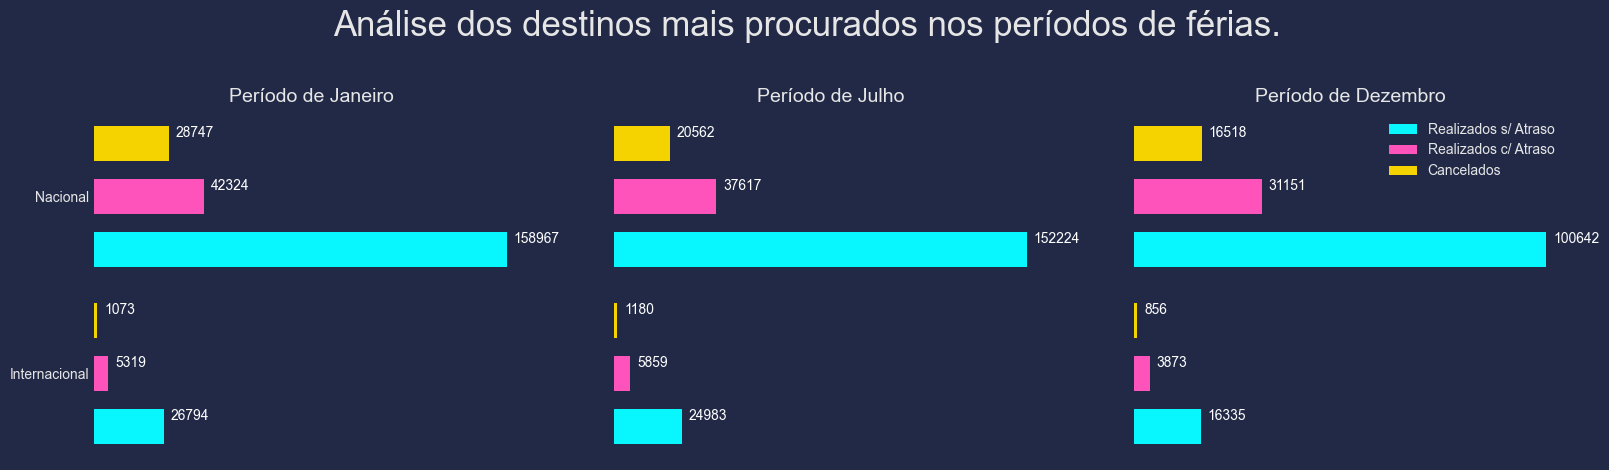

In [84]:
# Plot
Plot.periodo_ferias_geral(
    dataframe=voos_ferias_agg,
    periodo_ferias=AnacVoos.periodo_ferias(),
    grid=False,
    context='cyberpunk',
    figsize=(19, 10),
    suptitle='Análise dos destinos mais procurados nos períodos de férias.'
)

### 3.1.1 Principais destinos nacionais nos períodos de julho, dezembro e janeiro

In [85]:
# Dataframe
nacionais = list()
linha = 'Nacional'

for i, periodo in enumerate(AnacVoos.periodo_ferias()):
    nacionais.append(
        AnacVoos.get_voos_ferias_linha_periodo(
            cols_percentuais=[
                ['tx_realizados', 'realizados_s_atraso'],
                ['tx_atrasos', 'realizados_c_atraso'],
                ['tx_cancelados', 'cancelados']],
            cols_groupyby=['codigo_tipo_linha', 'periodo_ferias', 'rota'],
            linha=linha, 
            periodo=periodo,
            round=3
            )
        )
    print(f"10 Principais rotas nacionais no período de {periodo.title()}")
    for col_tx in nacionais[i].columns:
        if col_tx.__contains__('tx_'):
            nacionais[i][col_tx] = nacionais[i][col_tx].apply(lambda x: '{:.2%}'.format(x/100))
    display(nacionais[i])
    print()

nacionais: pd.DataFrame = pd.concat(nacionais)

10 Principais rotas nacionais no período de Janeiro


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,janeiro,SP - RJ,373.748621,7863,5136,0.65%,1644,0.21%,1083,0.14%
1,Nacional,janeiro,RJ - SP,374.050639,7657,4722,0.62%,1917,0.25%,1018,0.13%
2,Nacional,janeiro,MG - SP,494.685932,7037,4387,0.62%,1276,0.18%,1374,0.20%
3,Nacional,janeiro,SP - MG,494.456855,7005,4349,0.62%,1309,0.19%,1347,0.19%
4,Nacional,janeiro,SP - SP,316.936851,6867,4311,0.63%,1319,0.19%,1237,0.18%
5,Nacional,janeiro,SP - PR,460.953546,6655,4326,0.65%,1312,0.20%,1017,0.15%
6,Nacional,janeiro,PR - SP,467.911870,6520,4474,0.69%,1095,0.17%,951,0.15%
7,Nacional,janeiro,SC - SP,483.936402,5225,3900,0.75%,837,0.16%,488,0.09%
8,Nacional,janeiro,SP - SC,483.917626,5184,3755,0.72%,1011,0.20%,418,0.08%
9,Nacional,janeiro,SP - RS,849.117483,4834,3492,0.72%,802,0.17%,540,0.11%



10 Principais rotas nacionais no período de Julho


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,julho,SP - RJ,371.088259,7702,5619,0.73%,1365,0.18%,718,0.09%
1,Nacional,julho,RJ - SP,371.328531,7556,5567,0.74%,1326,0.17%,663,0.09%
2,Nacional,julho,SP - SP,321.987648,6699,4490,0.67%,1193,0.18%,1016,0.15%
3,Nacional,julho,MG - SP,498.681504,6350,4406,0.69%,1146,0.18%,798,0.13%
4,Nacional,julho,SP - MG,498.506009,6270,4435,0.71%,1088,0.17%,747,0.12%
5,Nacional,julho,SP - PR,467.932010,6220,4105,0.66%,1205,0.19%,910,0.15%
6,Nacional,julho,PR - SP,467.819262,6166,4205,0.68%,1063,0.17%,898,0.15%
7,Nacional,julho,SP - SC,487.293118,5056,3488,0.69%,1075,0.21%,493,0.10%
8,Nacional,julho,SC - SP,488.160812,5045,3637,0.72%,963,0.19%,445,0.09%
9,Nacional,julho,SP - RS,848.142164,4795,3374,0.70%,1065,0.22%,356,0.07%



10 Principais rotas nacionais no período de Dezembro


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,dezembro,SP - RJ,372.329633,5161,3245,0.63%,1322,0.26%,594,0.11%
1,Nacional,dezembro,RJ - SP,372.599970,5048,3130,0.62%,1357,0.27%,561,0.11%
2,Nacional,dezembro,SP - SP,321.243328,4654,2970,0.64%,1061,0.23%,623,0.13%
3,Nacional,dezembro,SP - PR,465.785811,4646,2953,0.64%,1036,0.22%,657,0.14%
4,Nacional,dezembro,MG - SP,496.335470,4503,2777,0.62%,1054,0.23%,672,0.15%
5,Nacional,dezembro,SP - MG,495.790955,4481,2756,0.61%,1026,0.23%,699,0.16%
6,Nacional,dezembro,PR - SP,472.158922,4468,3056,0.68%,866,0.19%,546,0.12%
7,Nacional,dezembro,SC - SP,485.526502,3500,2633,0.75%,575,0.16%,292,0.08%
8,Nacional,dezembro,SP - SC,485.081881,3482,2394,0.69%,812,0.23%,276,0.08%
9,Nacional,dezembro,SP - RS,849.512855,3139,2108,0.67%,725,0.23%,306,0.10%


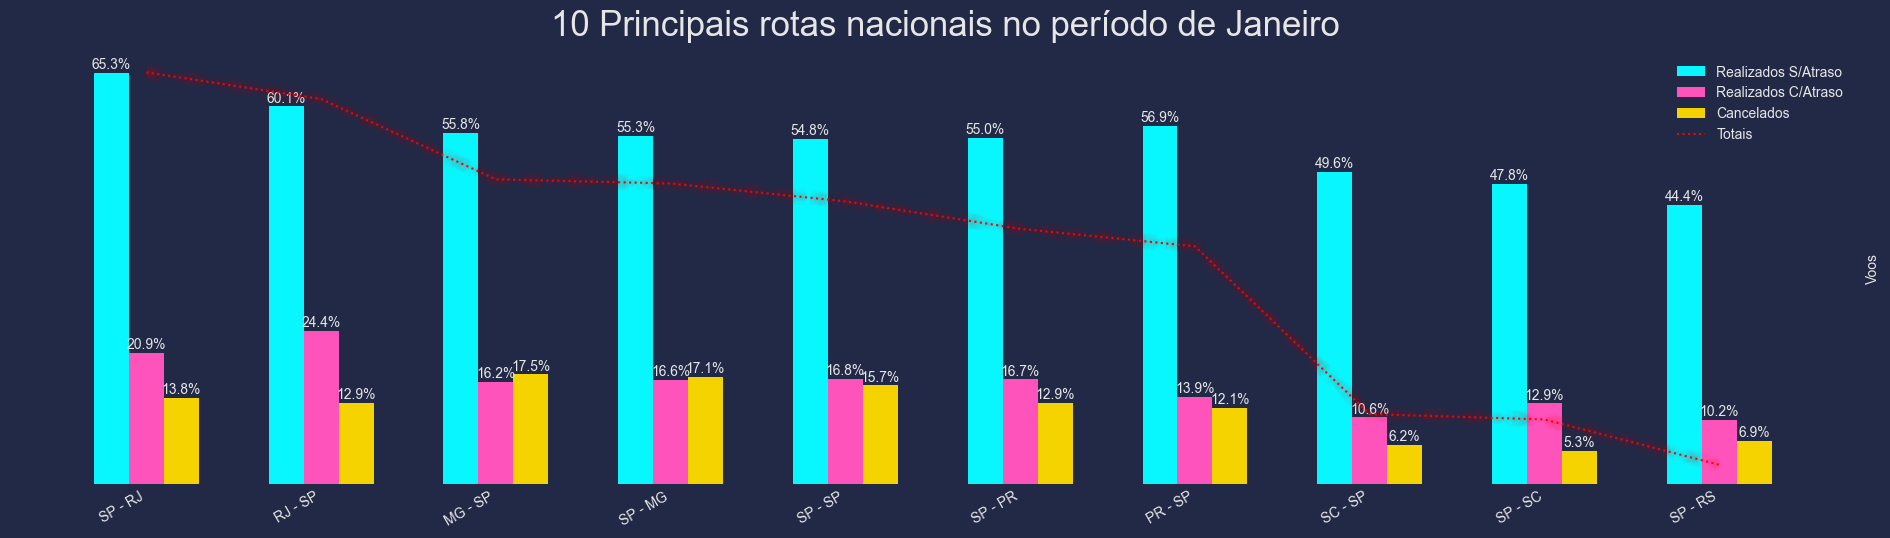

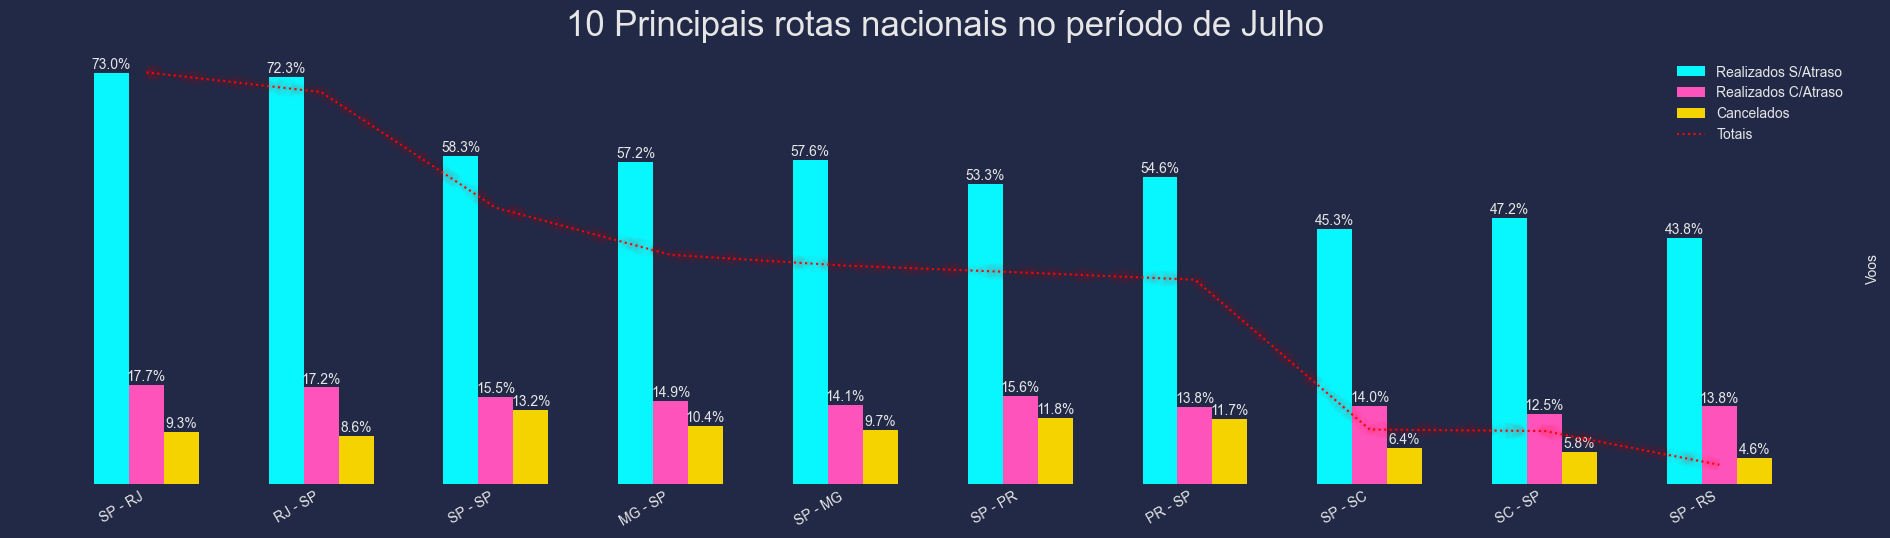

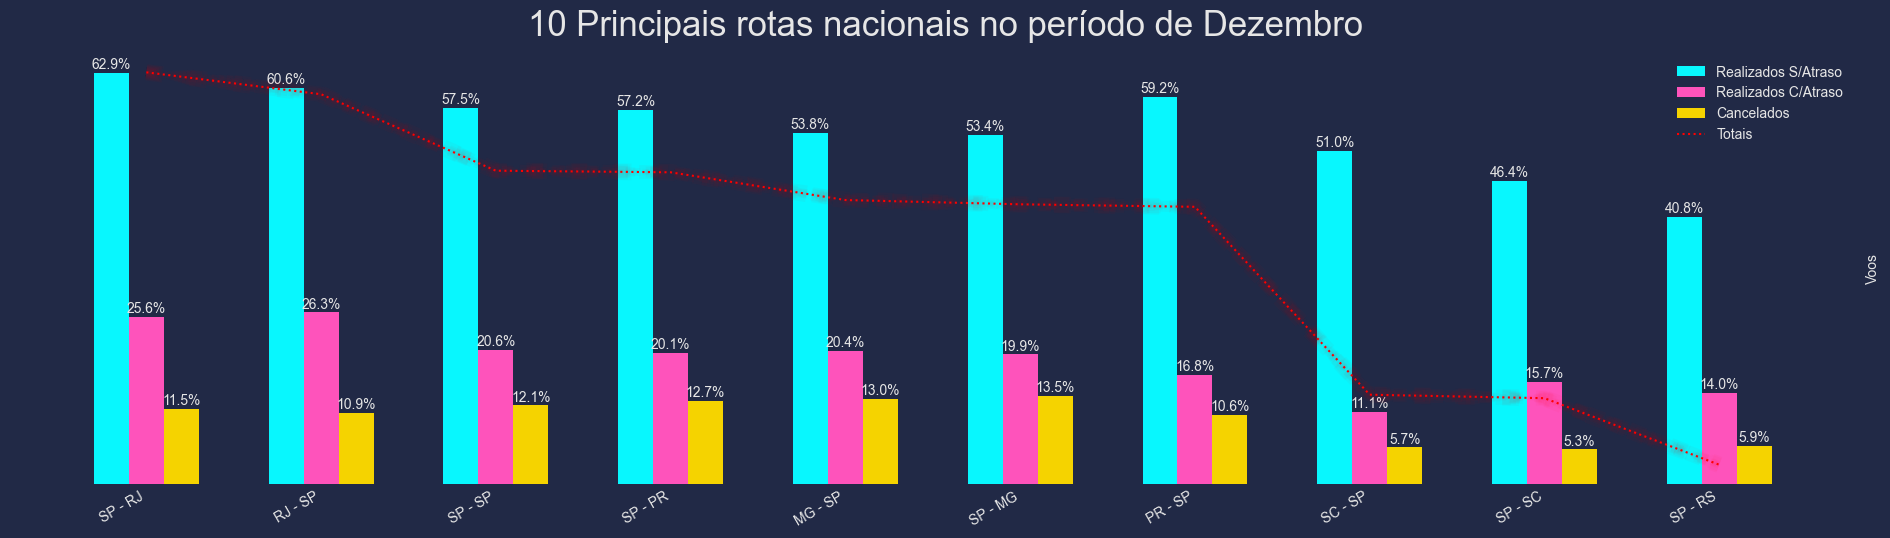

In [86]:
# Plot
for periodo in AnacVoos.periodo_ferias():
    Plot.periodo_ferias_tipo_linha(
        dataframe=nacionais.query("periodo_ferias == @periodo"),
        periodo_ferias=periodo,
        grid=False,
        context='cyberpunk',
        figsize=(19, 10),
        suptitle=f"10 Principais rotas nacionais no período de {periodo.title()}"
    )

### 3.1.2. Principais destinos internacionais nos períodos de julho, dezembro e janeiro

In [87]:
# Dataframe
internacionais = list()
linha = 'Internacional'

for i, periodo in enumerate(AnacVoos.periodo_ferias()):
    internacionais.append(
        AnacVoos.get_voos_ferias_linha_periodo(
            cols_percentuais=[
                ['tx_realizados', 'realizados_s_atraso'],
                ['tx_atrasos', 'realizados_c_atraso'],
                ['tx_cancelados', 'cancelados']],
            cols_groupyby=['codigo_tipo_linha', 'periodo_ferias', 'rota'],
            linha=linha, 
            periodo=periodo,
            round=3
            )
        )
    print(f"10 Principais rotas internacionais no período de {periodo.title()}")
    for col_tx in internacionais[i].columns:
        if col_tx.__contains__('tx_'):
            internacionais[i][col_tx] = internacionais[i][col_tx].apply(lambda x: '{:.2%}'.format(x/100))
    display(internacionais[i])
    print()

internacionais: pd.DataFrame = pd.concat(internacionais)

10 Principais rotas internacionais no período de Janeiro


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Internacional,janeiro,Argentina - Brasil,1794.421401,3734,3322,0.89%,284,0.08%,128,0.03%
1,Internacional,janeiro,Brasil - Argentina,1792.690477,3723,3239,0.87%,354,0.10%,130,0.04%
2,Internacional,janeiro,Estados Unidos - Brasil,7056.504499,3420,2449,0.72%,857,0.25%,114,0.03%
3,Internacional,janeiro,Brasil - Estados Unidos,7063.757805,3408,2806,0.82%,471,0.14%,131,0.04%
4,Internacional,janeiro,Brasil - Chile,2707.282341,1236,1035,0.84%,174,0.14%,27,0.02%
5,Internacional,janeiro,Chile - Brasil,2718.641457,1234,1036,0.84%,157,0.13%,41,0.03%
6,Internacional,janeiro,Brasil - Panama,4888.201733,1106,1068,0.97%,37,0.03%,1,0.00%
7,Internacional,janeiro,Panama - Brasil,4887.833317,1105,1042,0.94%,46,0.04%,17,0.01%
8,Internacional,janeiro,Brasil - Portugal,7070.122428,931,787,0.84%,115,0.12%,29,0.03%
9,Internacional,janeiro,Portugal - Brasil,7111.511235,921,751,0.81%,141,0.15%,29,0.03%



10 Principais rotas internacionais no período de Julho


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Internacional,julho,Brasil - Argentina,1883.656262,3570,2819,0.79%,531,0.15%,220,0.06%
1,Internacional,julho,Argentina - Brasil,1883.370878,3565,2827,0.79%,513,0.14%,225,0.06%
2,Internacional,julho,Estados Unidos - Brasil,7087.392259,3133,2141,0.68%,937,0.30%,55,0.02%
3,Internacional,julho,Brasil - Estados Unidos,7095.317683,3102,2568,0.83%,466,0.15%,68,0.02%
4,Internacional,julho,Brasil - Chile,2704.871919,1282,1031,0.80%,234,0.18%,17,0.01%
5,Internacional,julho,Chile - Brasil,2706.629388,1264,1039,0.82%,206,0.16%,19,0.01%
6,Internacional,julho,Brasil - Panama,4903.140868,1077,1028,0.95%,33,0.03%,16,0.01%
7,Internacional,julho,Panama - Brasil,4904.370463,1076,994,0.92%,61,0.06%,21,0.02%
8,Internacional,julho,Brasil - Portugal,7193.880090,1019,855,0.84%,128,0.13%,36,0.04%
9,Internacional,julho,Portugal - Brasil,7201.987263,1019,722,0.71%,255,0.25%,42,0.04%



10 Principais rotas internacionais no período de Dezembro


,codigo_tipo_linha,periodo_ferias,rota,distancia_media_km,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Internacional,dezembro,Brasil - Argentina,1831.355096,2300,1843,0.80%,346,0.15%,111,0.05%
1,Internacional,dezembro,Argentina - Brasil,1828.630884,2295,1875,0.82%,312,0.14%,108,0.05%
2,Internacional,dezembro,Estados Unidos - Brasil,7053.113233,2083,1494,0.72%,508,0.24%,81,0.04%
3,Internacional,dezembro,Brasil - Estados Unidos,7061.598274,2068,1700,0.82%,276,0.13%,92,0.04%
4,Internacional,dezembro,Brasil - Chile,2698.335774,838,711,0.85%,112,0.13%,15,0.02%
5,Internacional,dezembro,Chile - Brasil,2699.542235,830,696,0.84%,123,0.15%,11,0.01%
6,Internacional,dezembro,Panama - Brasil,4890.886511,693,657,0.95%,28,0.04%,8,0.01%
7,Internacional,dezembro,Brasil - Panama,4894.296753,692,666,0.96%,17,0.03%,9,0.01%
8,Internacional,dezembro,Portugal - Brasil,7112.089172,612,517,0.84%,56,0.09%,39,0.06%
9,Internacional,dezembro,Brasil - Portugal,7089.810988,611,538,0.88%,41,0.07%,32,0.05%


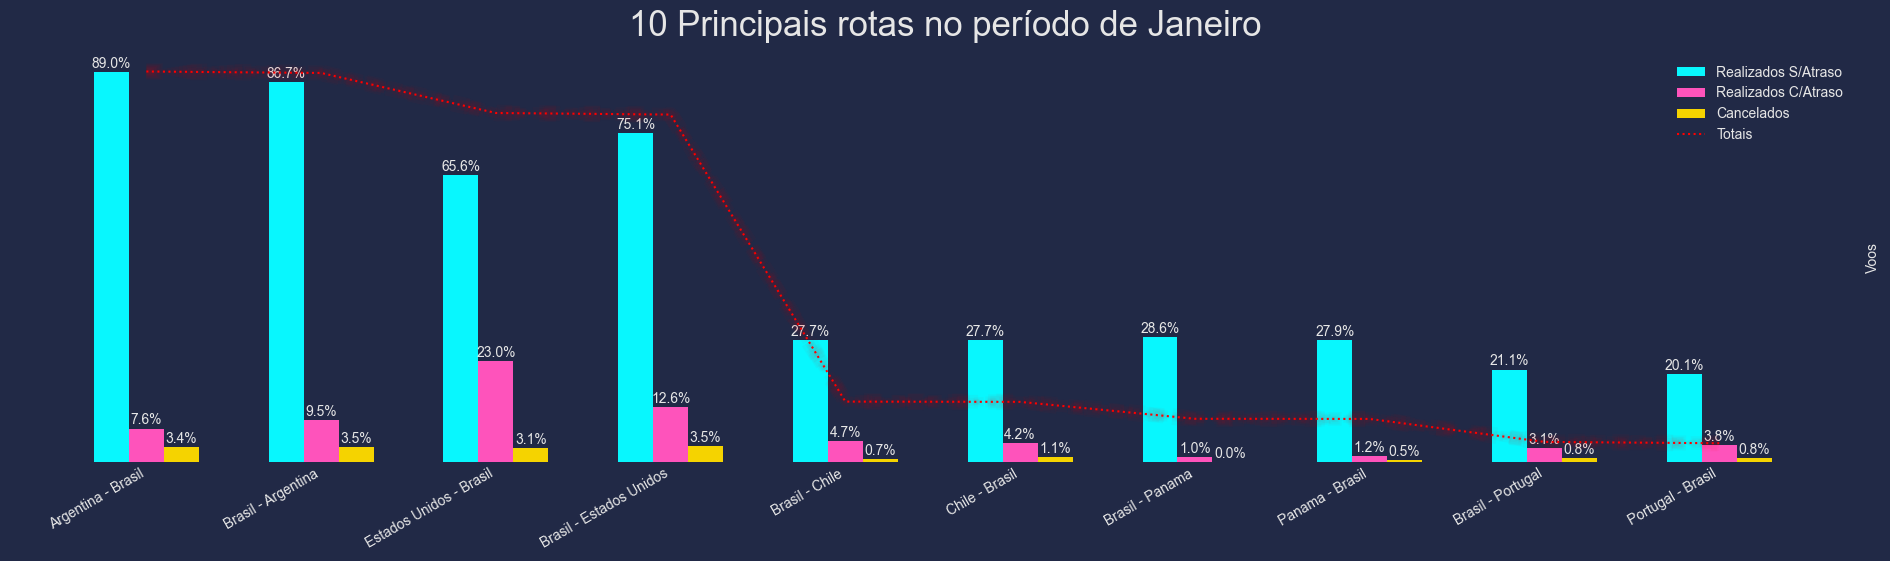

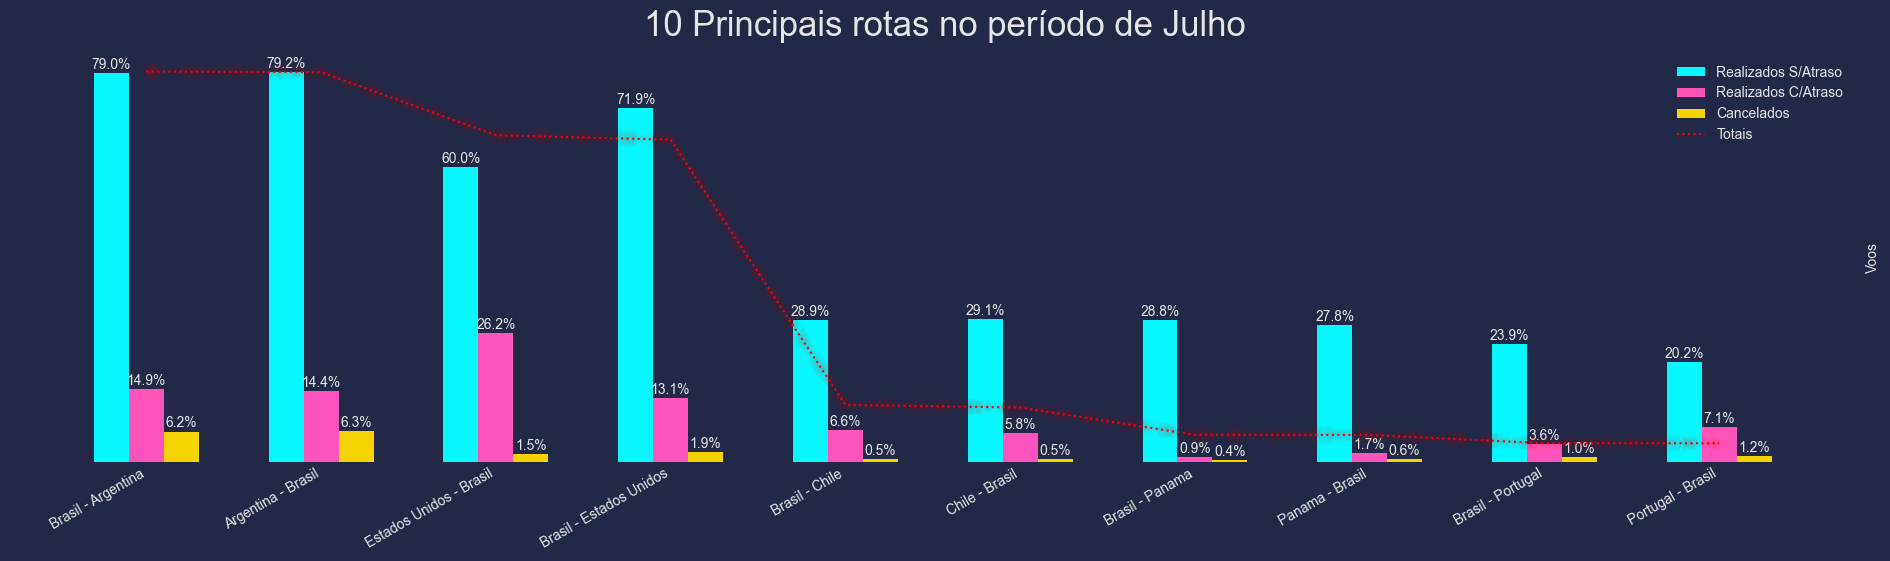

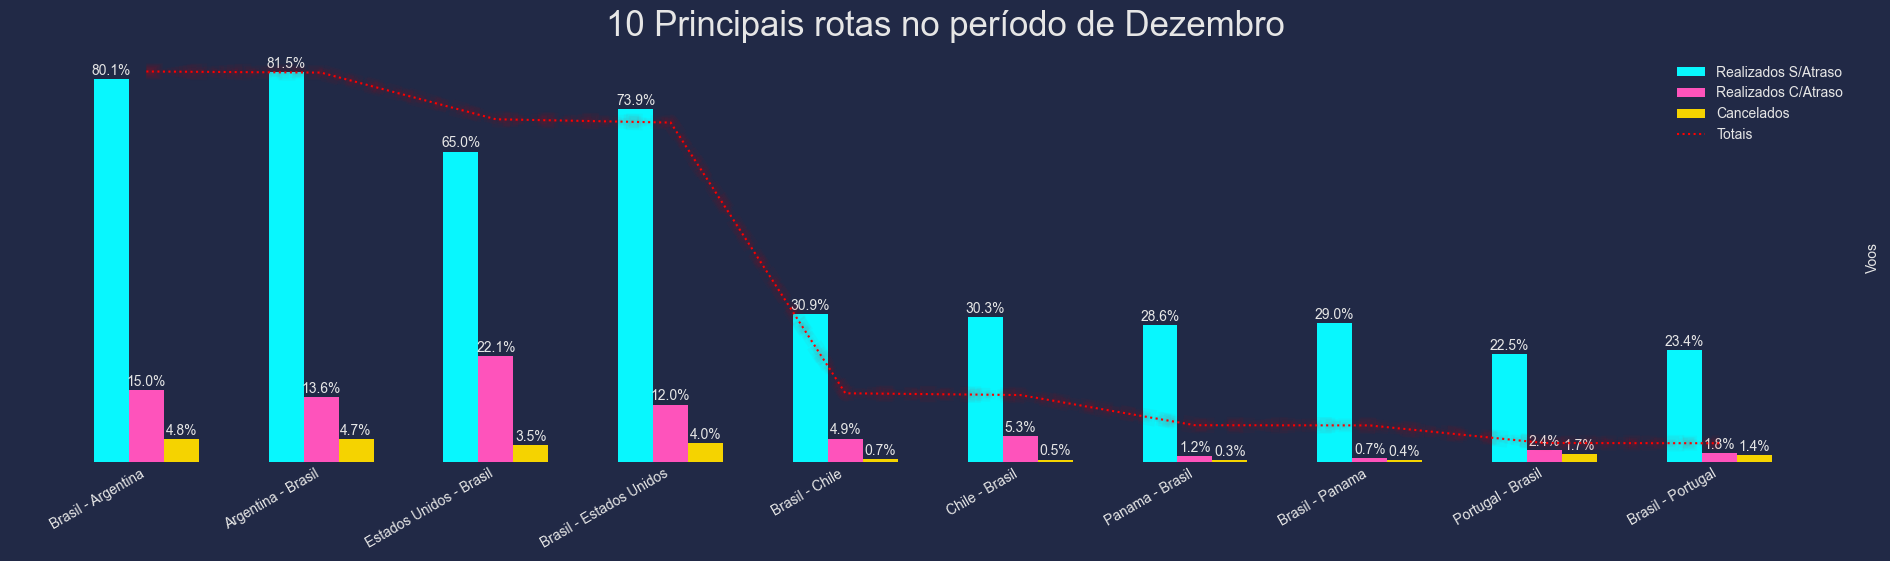

In [88]:
# Plot
for periodo in AnacVoos.periodo_ferias():
    Plot.periodo_ferias_tipo_linha(
        dataframe=internacionais.query("periodo_ferias == @periodo"),
        periodo_ferias=periodo,
        grid=False,
        context='cyberpunk',
        figsize=(19, 10),
        suptitle=f"10 Principais rotas no período de {periodo.title()}"
    )

## 3.2. Como ficam os aeroportos nesses meses?
Iremos analisar o aumento de atrasos, vôos cancelados, e os principais motivos, o dia mais provável de ter algum problema com o voo.

### 3.2.1. Atrasos

In [89]:
#Dataframe
total_voos, atrasos = AnacVoos.get_atrasos_voos_ferias(
                cols_groupby=['periodo_ferias', 'codigo_tipo_linha', 'justificativa_atraso'],
                converter_segundos_para_tempo=True,
            )

justificativas = atrasos.groupby('justificativa_atraso').agg(
    total_atrasos=('total_atrasos', 'sum'),
    tx_atrasos=('total_atrasos', lambda x: (x.sum() / total_voos).round(5))
).reset_index().sort_values(by='total_atrasos', ascending=False)

print(f"Total de atrasos para {total_voos} realizados nos períodos de férias:")
for col_tx in justificativas.columns:
    if col_tx.__contains__('tx_'):
        justificativas[col_tx] = justificativas[col_tx].apply(lambda x: '{:.4%}'.format(x/100))
display(justificativas)

Total de atrasos para 675024 realizados nos períodos de férias:


,justificativa_atraso,total_atrasos,tx_atrasos
2,Atraso não especificado,59022,0.0874%
11,Restrições operacionais no aeroporto,19692,0.0292%
4,Conexão de aeronave,13800,0.0204%
8,Interdição do aeroporto,10479,0.0155%
5,Defeitos da aeronave,9524,0.0141%
3,Condições meteorológicas,9151,0.0136%
12,Troca de aeronave,2759,0.0041%
0,Alternativa abaixo dos limites,1030,0.0015%
9,Ordem técnica,532,0.0008%
10,Pane na aeronave,120,0.0002%


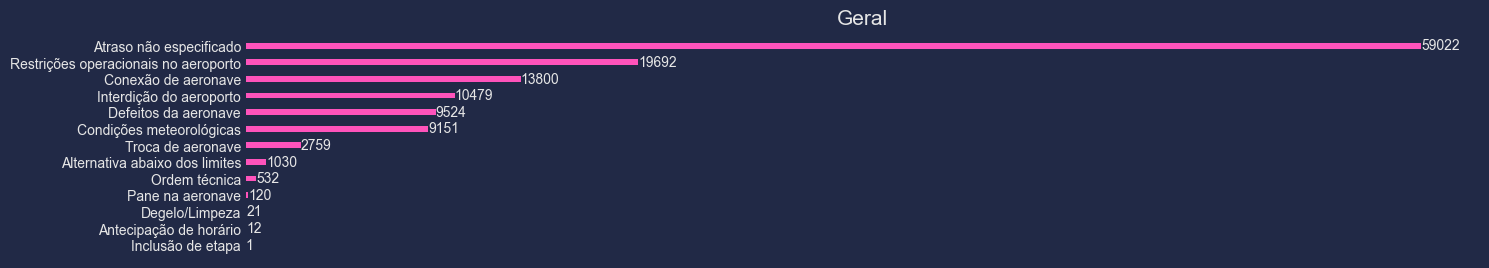

In [90]:
#Plot
Plot.atrasos_periodo_ferias(
            dataframe=justificativas, 
            periodo="Geral", 
            grid=False, 
            context='cyberpunk', 
            figsize=(15, 10))

#### 3.2.1.1 Atrasos em Janeiro

In [91]:
# Dataframe
periodo: str = 'janeiro'

for linha in AnacVoos.tipo_linha():
    print(f"Pincipais justificativas de cancelamento para voos realizados em {periodo.title()}:")
    display(atrasos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_atrasos'))
    print()

Pincipais justificativas de cancelamento para voos realizados em Janeiro:


,periodo_ferias,codigo_tipo_linha,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
35,janeiro,Nacional,Atraso não especificado,18725,00:27:51,00:30:05
43,janeiro,Nacional,Restrições operacionais no aeroporto,6365,00:22:32,00:27:08
37,janeiro,Nacional,Conexão de aeronave,5069,00:40:51,00:40:16
41,janeiro,Nacional,Interdição do aeroporto,4068,00:28:55,00:28:40
36,janeiro,Nacional,Condições meteorológicas,3392,00:57:30,00:56:02
38,janeiro,Nacional,Defeitos da aeronave,3297,00:53:32,00:50:56
44,janeiro,Nacional,Troca de aeronave,1011,01:15:31,01:11:54
34,janeiro,Nacional,Alternativa abaixo dos limites,392,00:58:23,00:57:17
42,janeiro,Nacional,Pane na aeronave,3,04:33:40,04:33:20
39,janeiro,Nacional,Degelo/Limpeza,1,00:14:00,00:23:00



Pincipais justificativas de cancelamento para voos realizados em Janeiro:


,periodo_ferias,codigo_tipo_linha,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
24,janeiro,Internacional,Atraso não especificado,3488,01:09:54,01:15:44
26,janeiro,Internacional,Conexão de aeronave,490,01:36:00,01:22:36
27,janeiro,Internacional,Defeitos da aeronave,452,02:02:49,01:52:41
32,janeiro,Internacional,Restrições operacionais no aeroporto,447,00:54:13,00:50:34
25,janeiro,Internacional,Condições meteorológicas,186,00:49:59,00:45:44
33,janeiro,Internacional,Troca de aeronave,92,01:33:20,01:27:10
29,janeiro,Internacional,Interdição do aeroporto,62,00:44:30,00:42:36
22,janeiro,Internacional,Alternativa abaixo dos limites,49,01:37:41,01:37:23
31,janeiro,Internacional,Pane na aeronave,36,12:57:26,12:51:08
28,janeiro,Internacional,Degelo/Limpeza,13,03:33:55,03:50:55


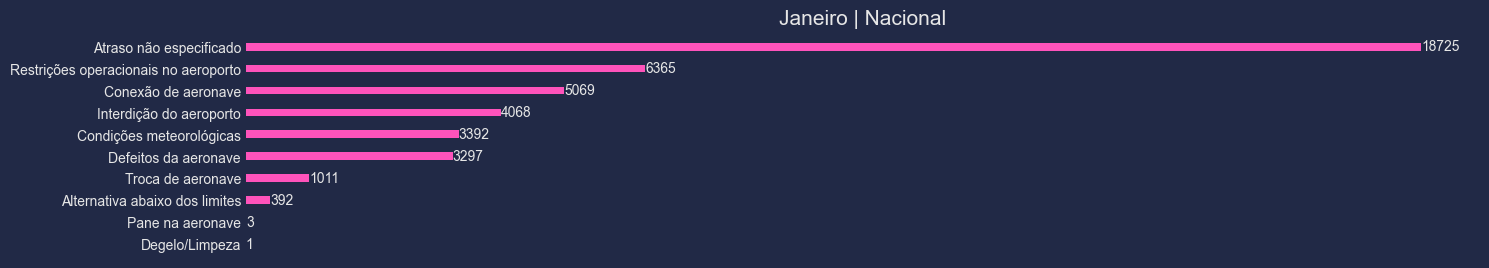

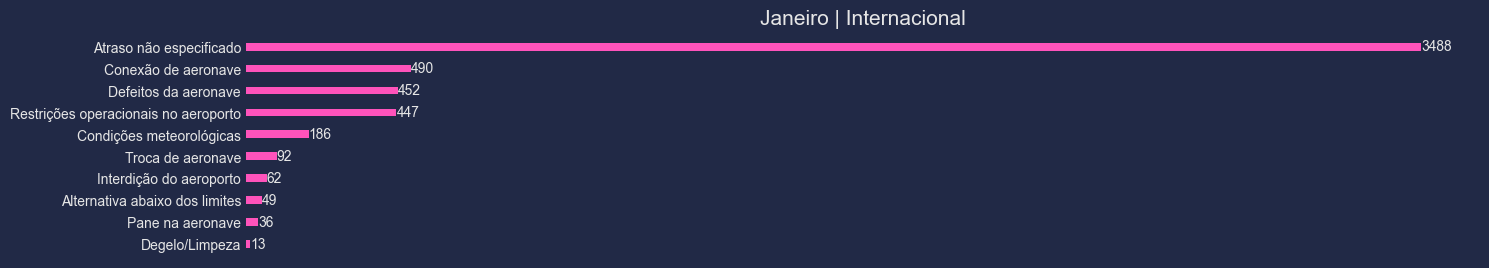

In [92]:
# Plot
for linha in AnacVoos.tipo_linha():
    Plot.atrasos_periodo_ferias(
                dataframe=atrasos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_atrasos'), 
                periodo=periodo,
                linha=linha, 
                grid=False, 
                context='cyberpunk', 
                figsize=(15, 10))

#### 3.2.1.2 Atrasos em Julho

In [93]:
# Dataframe
periodo: str = 'julho'

for linha in AnacVoos.tipo_linha():
    print(f"Pincipais justificativas de cancelamento para voos realizados em {periodo.title()}:")
    display(atrasos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_atrasos'))
    print()

Pincipais justificativas de cancelamento para voos realizados em Julho:


,periodo_ferias,codigo_tipo_linha,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
57,julho,Nacional,Atraso não especificado,16723,00:23:57,00:25:38
64,julho,Nacional,Restrições operacionais no aeroporto,6956,00:23:26,00:27:47
59,julho,Nacional,Conexão de aeronave,4153,00:35:14,00:34:47
62,julho,Nacional,Interdição do aeroporto,3096,00:25:35,00:25:37
60,julho,Nacional,Defeitos da aeronave,2798,00:50:32,00:47:47
58,julho,Nacional,Condições meteorológicas,2762,00:52:39,00:51:44
65,julho,Nacional,Troca de aeronave,868,01:12:00,01:08:03
56,julho,Nacional,Alternativa abaixo dos limites,251,01:18:24,01:15:52
63,julho,Nacional,Ordem técnica,8,00:22:22,00:28:30
61,julho,Nacional,Degelo/Limpeza,2,00:55:00,00:50:30



Pincipais justificativas de cancelamento para voos realizados em Julho:


,periodo_ferias,codigo_tipo_linha,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
47,julho,Internacional,Atraso não especificado,3717,01:01:15,01:08:13
54,julho,Internacional,Restrições operacionais no aeroporto,607,00:48:30,00:53:10
49,julho,Internacional,Conexão de aeronave,548,01:28:55,01:27:02
50,julho,Internacional,Defeitos da aeronave,497,01:59:34,01:58:11
48,julho,Internacional,Condições meteorológicas,175,00:55:44,00:58:15
51,julho,Internacional,Interdição do aeroporto,114,00:46:14,00:34:34
55,julho,Internacional,Troca de aeronave,103,01:41:01,01:35:26
53,julho,Internacional,Pane na aeronave,50,12:25:08,12:15:19
45,julho,Internacional,Alternativa abaixo dos limites,38,01:48:39,01:43:30
46,julho,Internacional,Antecipação de horário,9,00:29:26,00:04:13


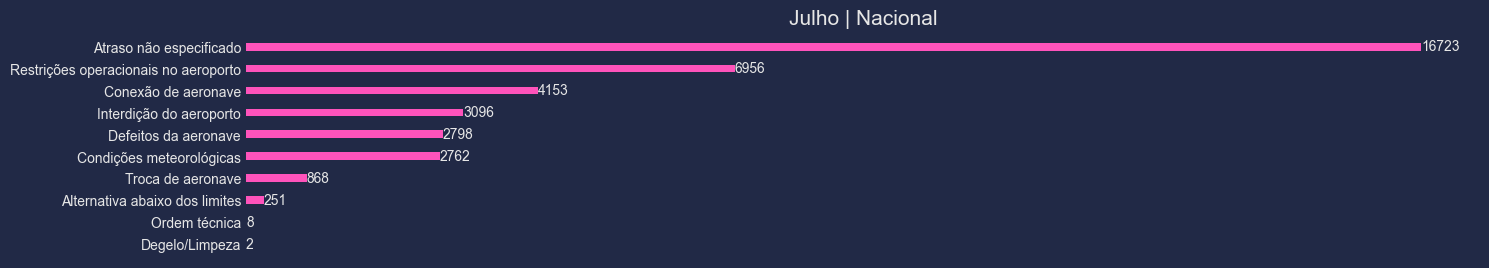

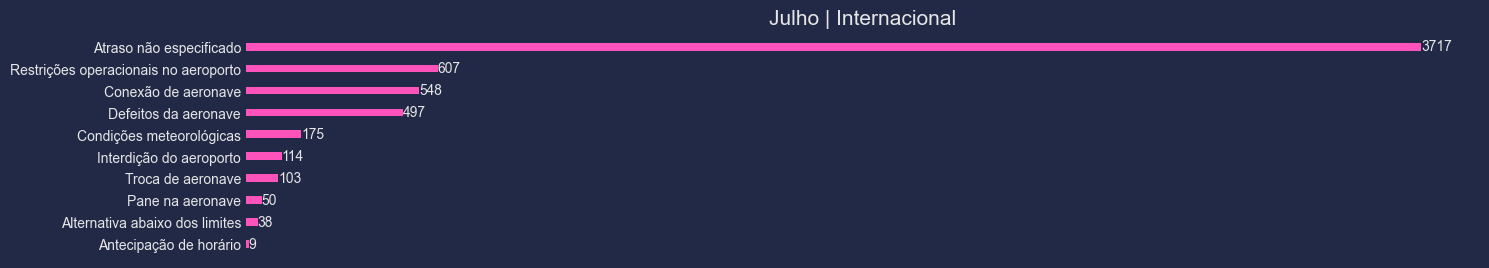

In [94]:
# Plot
for linha in AnacVoos.tipo_linha():
    Plot.atrasos_periodo_ferias(
                dataframe=atrasos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_atrasos'), 
                periodo=periodo,
                linha=linha, 
                grid=False, 
                context='cyberpunk', 
                figsize=(15, 10))

#### 3.2.1.3 Atrasos em Dezembro

In [95]:
# Dataframe
periodo: str = 'dezembro'

for linha in AnacVoos.tipo_linha():
    print(f"Pincipais justificativas de cancelamento para voos realizados em {periodo.title()}:")
    display(atrasos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_atrasos'))
    print()

Pincipais justificativas de cancelamento para voos realizados em Dezembro:


,periodo_ferias,codigo_tipo_linha,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
13,dezembro,Nacional,Atraso não especificado,13795,00:22:05,00:23:39
20,dezembro,Nacional,Restrições operacionais no aeroporto,4947,00:23:38,00:28:55
15,dezembro,Nacional,Conexão de aeronave,3231,00:38:02,00:39:27
18,dezembro,Nacional,Interdição do aeroporto,3085,00:31:05,00:30:59
14,dezembro,Nacional,Condições meteorológicas,2479,00:50:11,00:49:21
16,dezembro,Nacional,Defeitos da aeronave,2209,00:54:40,00:52:42
21,dezembro,Nacional,Troca de aeronave,632,01:15:48,01:13:40
19,dezembro,Nacional,Ordem técnica,497,00:29:22,00:34:07
12,dezembro,Nacional,Alternativa abaixo dos limites,272,00:52:19,00:51:55
17,dezembro,Nacional,Degelo/Limpeza,4,00:16:45,00:54:45



Pincipais justificativas de cancelamento para voos realizados em Dezembro:


,periodo_ferias,codigo_tipo_linha,justificativa_atraso,total_atrasos,media_atrasos_partida,media_atrasos_chegada
2,dezembro,Internacional,Atraso não especificado,2574,01:10:14,01:11:27
10,dezembro,Internacional,Restrições operacionais no aeroporto,370,00:53:24,00:51:11
4,dezembro,Internacional,Conexão de aeronave,309,01:39:11,01:23:44
5,dezembro,Internacional,Defeitos da aeronave,271,01:25:48,01:16:17
3,dezembro,Internacional,Condições meteorológicas,157,00:53:07,00:48:26
7,dezembro,Internacional,Interdição do aeroporto,54,01:01:51,00:51:47
11,dezembro,Internacional,Troca de aeronave,53,01:39:20,01:30:41
9,dezembro,Internacional,Pane na aeronave,31,12:02:44,11:48:38
0,dezembro,Internacional,Alternativa abaixo dos limites,28,01:19:32,01:14:12
8,dezembro,Internacional,Ordem técnica,23,00:41:52,00:41:20


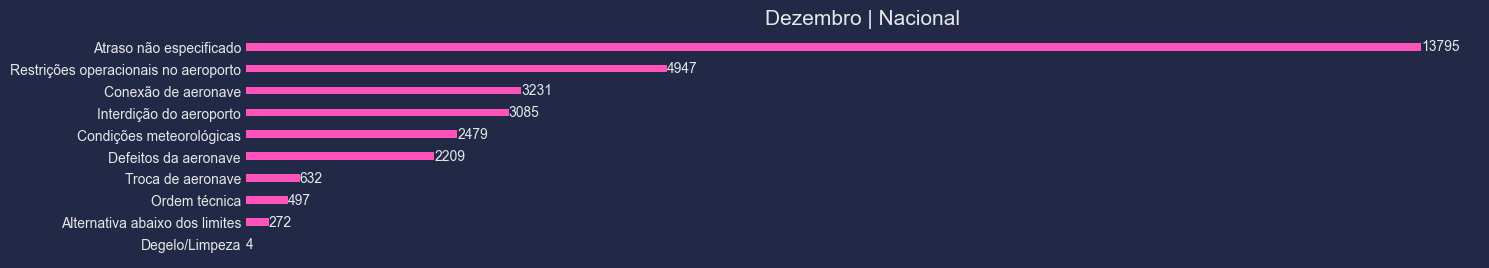

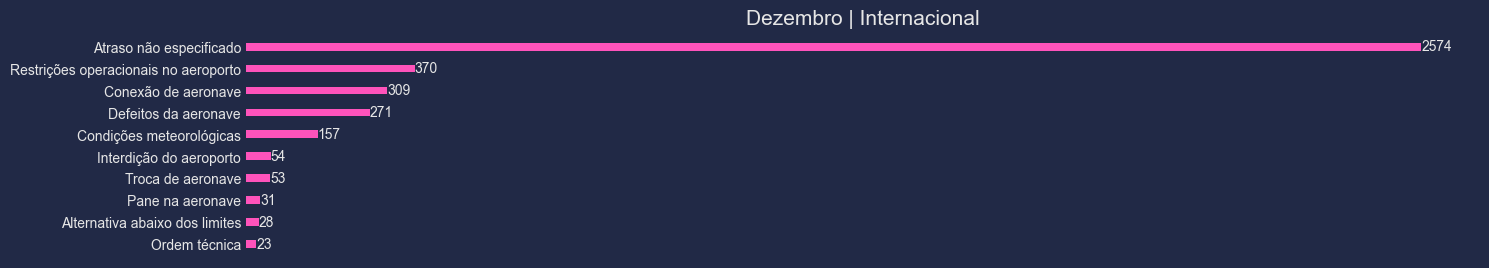

In [96]:
# Plot
for linha in AnacVoos.tipo_linha():
    Plot.atrasos_periodo_ferias(
                dataframe=atrasos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_atrasos'), 
                periodo=periodo,
                linha=linha, 
                grid=False, 
                context='cyberpunk', 
                figsize=(15, 10))

### 3.2.2. Cancelamentos

In [97]:
# Dataframe
cancelamentos = list()

for i, periodo in enumerate(AnacVoos.periodo_ferias()):
    for linha in AnacVoos.tipo_linha():
        t, c = AnacVoos.get_cancelamentos_voos_ferias(
            cols_groupby=['periodo_ferias', 'codigo_tipo_linha', 'justificativa_cancelamento'],
            col_tx='tx_cancelamentos',
            round=3,
            periodo=periodo,
            linha=linha
        )
        cancelamentos.append([t, c])

total_voos = [cancelamento[0] for cancelamento in cancelamentos]
cancelamentos: pd.DataFrame = pd.concat([cancelamento[1] for cancelamento in cancelamentos])

justificativas = cancelamentos.groupby('justificativa_cancelamento').agg(
    total_cancelamentos=('total_cancelamentos', 'sum'),
    tx_cancelamentos=('total_cancelamentos', lambda x: (x.sum() / sum(total_voos)).round(4))
).reset_index().sort_values(by='total_cancelamentos', ascending=False)

print(f"Total de cancelamentos para {sum(total_voos)} realizados nos períodos de férias:")
for col_tx in justificativas.columns:
    if col_tx.__contains__('tx_'):
        justificativas[col_tx] = justificativas[col_tx].apply(lambda x: '{:.5%}'.format(x/100))
display(justificativas)

Total de cancelamentos para 675024 realizados nos períodos de férias:


,justificativa_cancelamento,total_cancelamentos,tx_cancelamentos
0,Cancelamento não especificado,37955,0.05620%
5,Motivos técnicos-operacionais,27525,0.04080%
2,Falta de passageiros com passagem marcada,1940,0.00290%
3,Feriado nacional,1015,0.00150%
1,Condições meteorológicas,404,0.00060%
4,Interdição do aeroporto,97,0.00010%


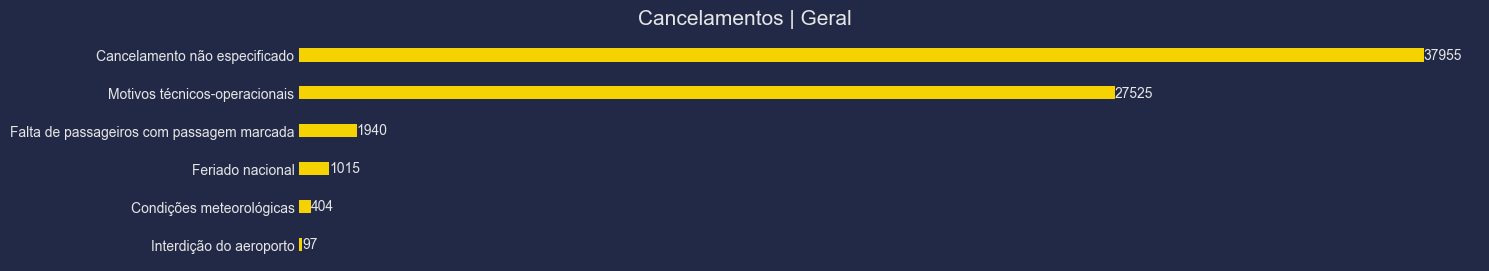

In [98]:
#Plot
Plot.justificativas_cancelamento(
    dataframe=justificativas,
    grid=False,
    context='cyberpunk',
    figsize=(15, 10),
    add_suptitle="Geral"
    )

#### 3.2.2.1 Cancelamentos em Janeiro

In [99]:
# Dataframe
periodo: str = 'janeiro'

for linha in AnacVoos.tipo_linha():
    print(f"Pincipais justificativas de cancelamento para voos realizados em {periodo.title()}:")
    cancelamentos_tipo_linha: pd.DataFrame = cancelamentos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_cancelamentos')
    for col_tx in cancelamentos_tipo_linha.columns:
        if col_tx.__contains__('tx_'):
            cancelamentos_tipo_linha[col_tx] = cancelamentos_tipo_linha[col_tx].apply(lambda x: '{:.2%}'.format(x/100))
    display(cancelamentos_tipo_linha)
    print()

Pincipais justificativas de cancelamento para voos realizados em Janeiro:


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos,tx_cancelamentos
5,janeiro,Nacional,Motivos técnicos-operacionais,14132,0.06%
0,janeiro,Nacional,Cancelamento não especificado,13066,0.06%
2,janeiro,Nacional,Falta de passageiros com passagem marcada,719,0.00%
3,janeiro,Nacional,Feriado nacional,673,0.00%
1,janeiro,Nacional,Condições meteorológicas,113,0.00%
4,janeiro,Nacional,Interdição do aeroporto,44,0.00%



Pincipais justificativas de cancelamento para voos realizados em Janeiro:


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos,tx_cancelamentos
3,janeiro,Internacional,Motivos técnicos-operacionais,611,0.02%
0,janeiro,Internacional,Cancelamento não especificado,448,0.01%
1,janeiro,Internacional,Feriado nacional,13,0.00%
2,janeiro,Internacional,Interdição do aeroporto,1,0.00%


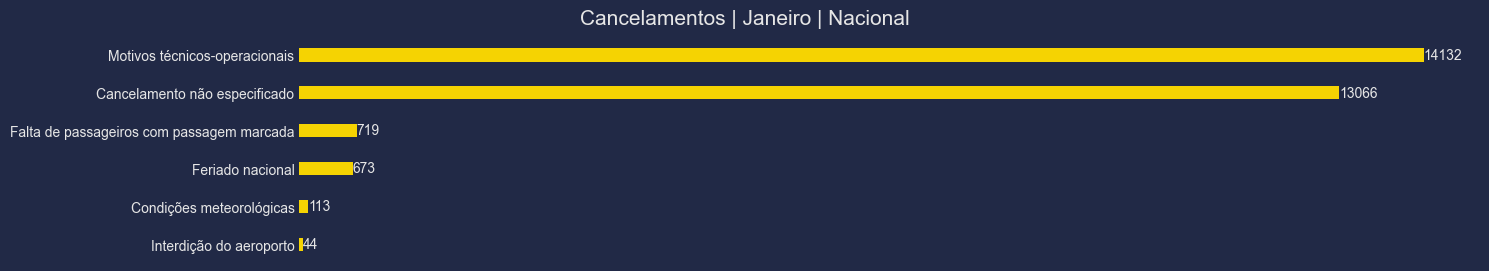

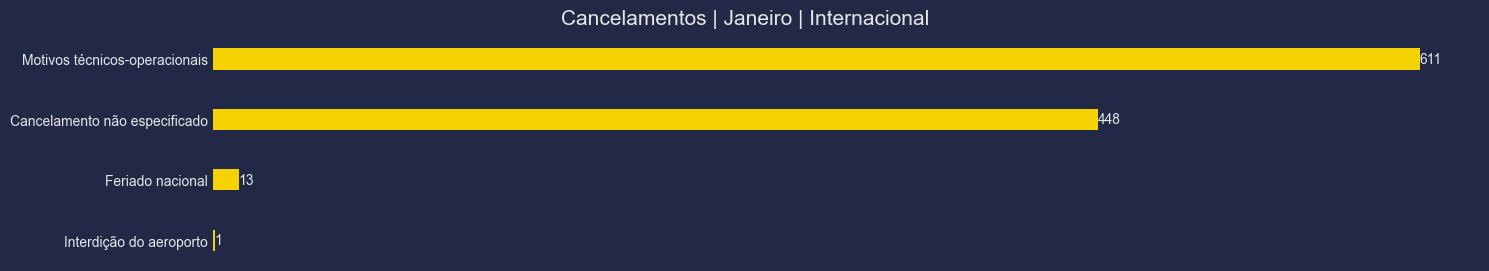

In [100]:
#Plot
for linha in AnacVoos.tipo_linha():
    Plot.justificativas_cancelamento(
        dataframe=cancelamentos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_cancelamentos'),
        grid=False,
        context='cyberpunk',
        figsize=(15, 10),
        add_suptitle=periodo
        )

#### 3.2.2.2 Cancelamentos em Julho

In [101]:
# Dataframe
periodo: str = 'julho'

for linha in AnacVoos.tipo_linha():
    print(f"Pincipais justificativas de cancelamento para voos realizados em {periodo.title()}:")
    cancelamentos_tipo_linha: pd.DataFrame = cancelamentos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_cancelamentos')
    for col_tx in cancelamentos_tipo_linha.columns:
        if col_tx.__contains__('tx_'):
            cancelamentos_tipo_linha[col_tx] = cancelamentos_tipo_linha[col_tx].apply(lambda x: '{:.2%}'.format(x/100))
    display(cancelamentos_tipo_linha)
    print()

Pincipais justificativas de cancelamento para voos realizados em Julho:


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos,tx_cancelamentos
0,julho,Nacional,Cancelamento não especificado,13209,0.06%
5,julho,Nacional,Motivos técnicos-operacionais,6605,0.03%
2,julho,Nacional,Falta de passageiros com passagem marcada,541,0.00%
1,julho,Nacional,Condições meteorológicas,167,0.00%
3,julho,Nacional,Feriado nacional,25,0.00%
4,julho,Nacional,Interdição do aeroporto,15,0.00%



Pincipais justificativas de cancelamento para voos realizados em Julho:


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos,tx_cancelamentos
4,julho,Internacional,Motivos técnicos-operacionais,675,0.02%
0,julho,Internacional,Cancelamento não especificado,455,0.01%
2,julho,Internacional,Feriado nacional,44,0.00%
3,julho,Internacional,Interdição do aeroporto,5,0.00%
1,julho,Internacional,Condições meteorológicas,1,0.00%


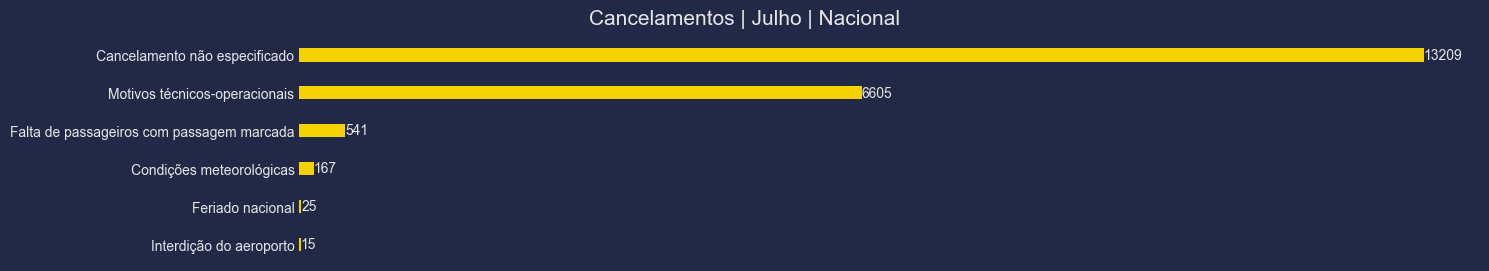

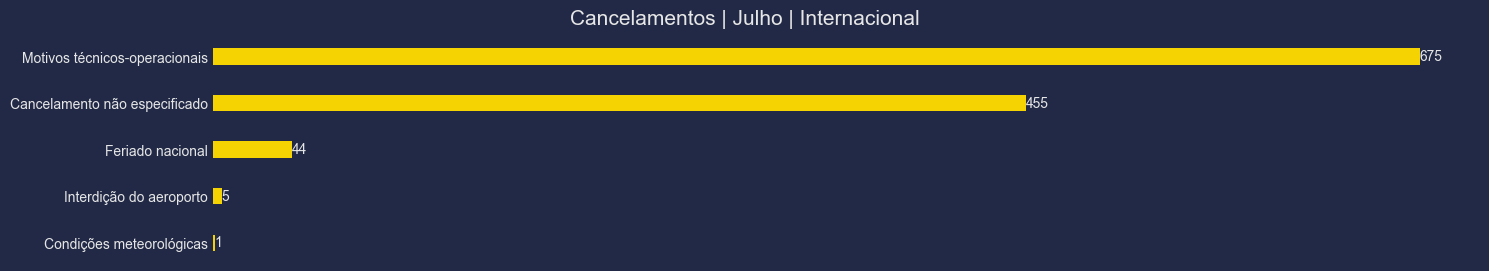

In [102]:
#Plot
for linha in AnacVoos.tipo_linha():
    Plot.justificativas_cancelamento(
        dataframe=cancelamentos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo'),
        grid=False,
        context='cyberpunk',
        figsize=(15, 10),
        add_suptitle=periodo
        )

#### 3.2.2.3 Cancelamentos em Dezembro

In [103]:
# Dataframe
periodo: str = 'dezembro'

for linha in AnacVoos.tipo_linha():
    print(f"Pincipais justificativas de cancelamento para voos realizados em {periodo.title()}:")
    cancelamentos_tipo_linha: pd.DataFrame = cancelamentos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo').nlargest(10, 'total_cancelamentos')
    for col_tx in cancelamentos_tipo_linha.columns:
        if col_tx.__contains__('tx_'):
            cancelamentos_tipo_linha[col_tx] = cancelamentos_tipo_linha[col_tx].apply(lambda x: '{:.2%}'.format(x/100))
    display(cancelamentos_tipo_linha)
    print()

Pincipais justificativas de cancelamento para voos realizados em Dezembro:


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos,tx_cancelamentos
0,dezembro,Nacional,Cancelamento não especificado,10349,0.07%
5,dezembro,Nacional,Motivos técnicos-operacionais,5096,0.03%
2,dezembro,Nacional,Falta de passageiros com passagem marcada,680,0.01%
3,dezembro,Nacional,Feriado nacional,244,0.00%
1,dezembro,Nacional,Condições meteorológicas,121,0.00%
4,dezembro,Nacional,Interdição do aeroporto,28,0.00%



Pincipais justificativas de cancelamento para voos realizados em Dezembro:


,periodo_ferias,codigo_tipo_linha,justificativa_cancelamento,total_cancelamentos,tx_cancelamentos
0,dezembro,Internacional,Cancelamento não especificado,428,0.02%
4,dezembro,Internacional,Motivos técnicos-operacionais,406,0.02%
2,dezembro,Internacional,Feriado nacional,16,0.00%
3,dezembro,Internacional,Interdição do aeroporto,4,0.00%
1,dezembro,Internacional,Condições meteorológicas,2,0.00%


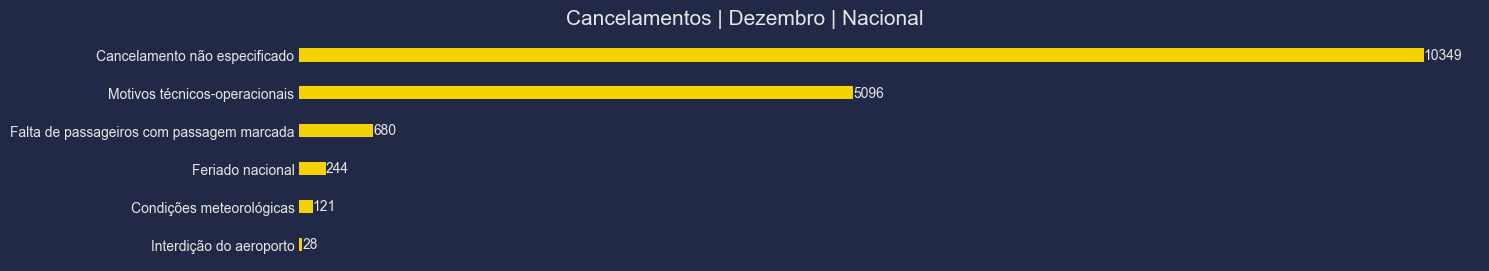

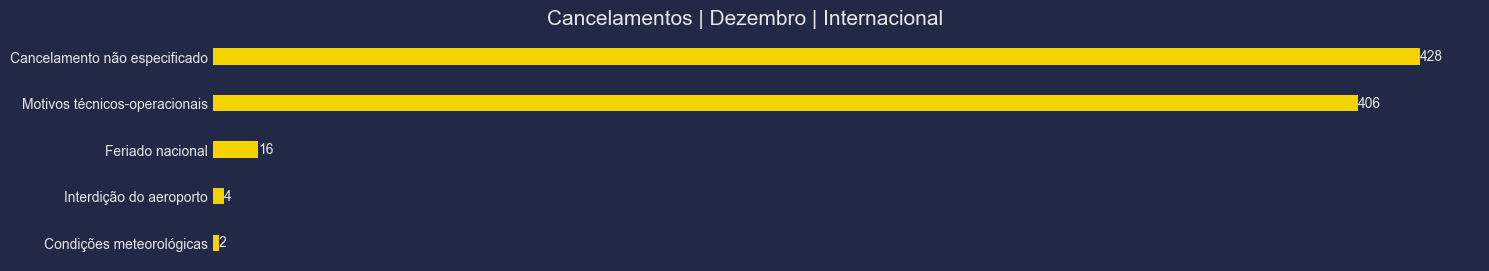

In [104]:
#Plot
for linha in AnacVoos.tipo_linha():
    Plot.justificativas_cancelamento(
        dataframe=cancelamentos.query('codigo_tipo_linha == @linha and periodo_ferias == @periodo'),
        grid=False,
        context='cyberpunk',
        figsize=(15, 10),
        add_suptitle=periodo
        )

## 3.3. Qual a melhor opção uma viagem nacional ou internacional?
Após as análises da questão 02, vamos analisar se existe algum favorecimento de vôos internacionais sobre os nacionais.

In [105]:
#Dataframe
for linha in AnacVoos.tipo_linha():
    resumo = AnacVoos.get_voos_ferias_resumo(
        cols_groupby = ['codigo_tipo_linha', 'periodo_ferias'],
        col_tx = [
            ['tx_realizados', 'realizados_s_atraso'],
            ['tx_atrasos', 'realizados_c_atraso'],
            ['tx_cancelados', 'cancelados']
        ],
        round=3,
        ordenar_resumo=True,
        formatar_txs=True,
        linha=linha
    )

    display(resumo)


,codigo_tipo_linha,periodo_ferias,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Nacional,dezembro,148311,100642,0.68%,31151,0.21%,16518,0.11%
1,Nacional,janeiro,230038,158967,0.69%,42324,0.18%,28747,0.12%
2,Nacional,julho,210403,152224,0.72%,37617,0.18%,20562,0.10%


,codigo_tipo_linha,periodo_ferias,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,Internacional,dezembro,21064,16335,0.78%,3873,0.18%,856,0.04%
1,Internacional,janeiro,33186,26794,0.81%,5319,0.16%,1073,0.03%
2,Internacional,julho,32022,24983,0.78%,5859,0.18%,1180,0.04%


## 3.4. Qual a melhor rota?
Aqui faremos o DE-PARA entre os  aeroporto origem/destino, para os principais destinos, levantados na pergunta 01.

In [106]:
# Dataframe Internacional
voos_ferias = AnacVoos.get_voos_ferias()

internacionais = voos_ferias[voos_ferias['codigo_tipo_linha'] == 'Internacional']\
    .groupby(['periodo_ferias', 'rota']).size()\
    .reset_index(name='voos')

nacionais = voos_ferias[voos_ferias['codigo_tipo_linha'] == 'Nacional']\
    .groupby(['periodo_ferias', 'rota']).size()\
    .reset_index(name='voos')

for periodo in AnacVoos.periodo_ferias():
    internacionais_periodo = internacionais.query("periodo_ferias == @periodo")
    nacionais_periodo = nacionais.query("periodo_ferias == @periodo")

    top_internacionais = internacionais_periodo.nlargest(1, 'voos')
    top_nacionais = nacionais_periodo.nlargest(1, 'voos')

    print(f"Comparando os destinos mais procurados no período de {periodo}:")

    if not top_internacionais.empty and not top_nacionais.empty:
        if top_internacionais['voos'].values[0] > top_nacionais['voos'].values[0]:
            print("O destino internacional mais procurado supera o destino nacional mais procurado.")
        elif top_internacionais['voos'].values[0] < top_nacionais['voos'].values[0]:
            print("O destino nacional mais procurado supera o destino internacional mais procurado.")
        else:
            print("O destino internacional e o destino nacional mais procurados têm a mesma quantidade de voos.")

        print("Destino internacional mais procurado:")
        display(top_internacionais.reset_index(drop=True))

        print("Destino nacional mais procurado:")
        display(top_nacionais.reset_index(drop=True))
    elif not top_internacionais.empty:
        print("Não foram encontrados destinos nacionais mais procurados neste período.")

        print("Destino internacional mais procurado:")
        display(top_internacionais.reset_index(drop=True))
    elif not top_nacionais.empty:
        print("Não foram encontrados destinos internacionais mais procurados neste período.")

        print("Destino nacional mais procurado:")
        display(top_nacionais.reset_index(drop=True))
    else:
        print("Não foram encontrados destinos internacionais nem nacionais mais procurados neste período.")

    print()

Comparando os destinos mais procurados no período de janeiro:
O destino nacional mais procurado supera o destino internacional mais procurado.
Destino internacional mais procurado:


,periodo_ferias,rota,voos
0,janeiro,Argentina - Brasil,3734


Destino nacional mais procurado:


,periodo_ferias,rota,voos
0,janeiro,SP - RJ,7863



Comparando os destinos mais procurados no período de julho:
O destino nacional mais procurado supera o destino internacional mais procurado.
Destino internacional mais procurado:


,periodo_ferias,rota,voos
0,julho,Brasil - Argentina,3570


Destino nacional mais procurado:


,periodo_ferias,rota,voos
0,julho,SP - RJ,7702



Comparando os destinos mais procurados no período de dezembro:
O destino nacional mais procurado supera o destino internacional mais procurado.
Destino internacional mais procurado:


,periodo_ferias,rota,voos
0,dezembro,Brasil - Argentina,2300


Destino nacional mais procurado:


,periodo_ferias,rota,voos
0,dezembro,SP - RJ,5161


## 3.5. Qual melhor dia da semana para pegar um vôo?
Iremos cruzar as informações de cancelamentos e atrasados com os dias da semana e verificar qual o dia tem uma menor probabilidade de ter algum problema.

In [107]:
resumo_semanas = AnacVoos.get_voos_ferias_resumo(
    cols_groupby=['dia_semana'],
    col_tx=[
        ['tx_realizados', 'realizados_s_atraso'],
        ['tx_atrasos', 'realizados_c_atraso'],
        ['tx_cancelados', 'cancelados']],
    round=2,
    ordenar_resumo=True,
    formatar_txs=True,
    marcar_txs=True,
)

print(f"Geral: Nacional e Internacional")
display(resumo_semanas)

Geral: Nacional e Internacional


,dia_semana,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,domingo,88516,65762,0.74%,15292,0.17%,7462,0.08%
1,quarta-feira,96735,67959,0.70%,18234,0.19%,10542,0.11%
2,quinta-feira,104078,71455,0.69%,20622,0.20%,12001,0.12%
3,segunda-feira,98391,70244,0.71%,18911,0.19%,9236,0.09%
4,sexta-feira,108070,75239,0.70%,21314,0.20%,11517,0.11%
5,sábado,83778,61717,0.74%,14040,0.17%,8021,0.10%
6,terça-feira,95456,67569,0.71%,17730,0.19%,10157,0.11%


### 3.5.1. Qual melhor dia da semana para pegar um vôo Nacional?

In [108]:
linha: str = 'Nacional'

for periodo in AnacVoos.periodo_ferias():
    resumo_semanas = AnacVoos.get_voos_ferias_resumo(
        cols_groupby=['dia_semana'],
        col_tx=[
            ['tx_realizados', 'realizados_s_atraso'],
            ['tx_atrasos', 'realizados_c_atraso'],
            ['tx_cancelados', 'cancelados']],
        round=2,
        ordenar_resumo=True,
        formatar_txs=True,
        marcar_txs=True,

        linha=linha,
        periodo=periodo
    )

    print(f"{linha} - {periodo}:")
    display(resumo_semanas) and print()

Nacional - janeiro:


,dia_semana,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,domingo,30728,22345,0.73%,5170,0.17%,3213,0.10%
1,quarta-feira,31222,20899,0.67%,6179,0.20%,4144,0.13%
2,quinta-feira,34309,22574,0.66%,6994,0.20%,4741,0.14%
3,segunda-feira,34316,23710,0.69%,6738,0.20%,3868,0.11%
4,sexta-feira,37594,25655,0.68%,6792,0.18%,5147,0.14%
5,sábado,28531,20698,0.73%,4354,0.15%,3479,0.12%
6,terça-feira,33338,23086,0.69%,6097,0.18%,4155,0.12%


Nacional - julho:


,dia_semana,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,domingo,28001,21456,0.77%,4261,0.15%,2284,0.08%
1,quarta-feira,31283,22437,0.72%,5448,0.17%,3398,0.11%
2,quinta-feira,31723,22420,0.71%,6059,0.19%,3244,0.10%
3,segunda-feira,31732,23382,0.74%,5379,0.17%,2971,0.09%
4,sexta-feira,34500,23962,0.69%,7224,0.21%,3314,0.10%
5,sábado,24862,18200,0.73%,4359,0.18%,2303,0.09%
6,terça-feira,28302,20367,0.72%,4887,0.17%,3048,0.11%


Nacional - dezembro:


,dia_semana,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,domingo,16952,11953,0.71%,3471,0.20%,1528,0.09%
1,quarta-feira,22832,15643,0.69%,4609,0.20%,2580,0.11%
2,quinta-feira,25360,16491,0.65%,5364,0.21%,3505,0.14%
3,segunda-feira,20629,13870,0.67%,4746,0.23%,2013,0.10%
4,sexta-feira,23074,15405,0.67%,5095,0.22%,2574,0.11%
5,sábado,16873,11983,0.71%,3064,0.18%,1826,0.11%
6,terça-feira,22591,15297,0.68%,4802,0.21%,2492,0.11%


### 3.5.2. Qual melhor dia da semana para pegar um vôo Internacional?

In [109]:
linha: str = 'Internacional'

for periodo in AnacVoos.periodo_ferias():
    resumo_semanas = AnacVoos.get_voos_ferias_resumo(
        cols_groupby=['dia_semana'],
        col_tx=[
            ['tx_realizados', 'realizados_s_atraso'],
            ['tx_atrasos', 'realizados_c_atraso'],
            ['tx_cancelados', 'cancelados']],
        round=2,
        ordenar_resumo=True,
        formatar_txs=True,
        marcar_txs=True,

        linha=linha,
        periodo=periodo
    )

    print(f"{linha} - {periodo}:")
    display(resumo_semanas) and print()

Internacional - janeiro:


,dia_semana,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,domingo,5069,3979,0.78%,927,0.18%,163,0.03%
1,quarta-feira,4118,3343,0.81%,631,0.15%,144,0.03%
2,quinta-feira,4741,3855,0.81%,720,0.15%,166,0.04%
3,segunda-feira,4601,3683,0.80%,796,0.17%,122,0.03%
4,sexta-feira,5019,4101,0.82%,750,0.15%,168,0.03%
5,sábado,5230,4324,0.83%,769,0.15%,137,0.03%
6,terça-feira,4408,3509,0.80%,726,0.16%,173,0.04%


Internacional - julho:


,dia_semana,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,domingo,4982,3909,0.78%,908,0.18%,165,0.03%
1,quarta-feira,4334,3352,0.77%,818,0.19%,164,0.04%
2,quinta-feira,4490,3485,0.78%,828,0.18%,177,0.04%
3,segunda-feira,4405,3484,0.79%,763,0.17%,158,0.04%
4,sexta-feira,4858,3761,0.77%,895,0.18%,202,0.04%
5,sábado,5063,3962,0.78%,960,0.19%,141,0.03%
6,terça-feira,3890,3030,0.78%,687,0.18%,173,0.04%


Internacional - dezembro:


,dia_semana,voos,realizados_s_atraso,tx_realizados,realizados_c_atraso,tx_atrasos,cancelados,tx_cancelados
0,domingo,2784,2120,0.76%,555,0.20%,109,0.04%
1,quarta-feira,2946,2285,0.78%,549,0.19%,112,0.04%
2,quinta-feira,3455,2630,0.76%,657,0.19%,168,0.05%
3,segunda-feira,2708,2115,0.78%,489,0.18%,104,0.04%
4,sexta-feira,3025,2355,0.78%,558,0.18%,112,0.04%
5,sábado,3219,2550,0.79%,534,0.17%,135,0.04%
6,terça-feira,2927,2280,0.78%,531,0.18%,116,0.04%


## 4.1. Resumo da base:

In [110]:
AnacVoos.tempo_execucao = time.time()-AnacVoos.tempo_execucao
print("Total de arquivos processados:", AnacVoos.total_arquivos)
print("Total de registros processados:", AnacVoos.total_registros)
print("Dados sólidos:", AnacVoos.dados_solidos)
print("Tempo de execução:", Utils.formatar_tempo_execucao(AnacVoos.tempo_execucao))

Total de arquivos processados: 944
Total de registros processados: 2542519
Dados sólidos: True
Tempo de execução: 00:08:46
